## Chapter 18 - Metric Predicted Variable with Multiple Metric Predictors

- [18.1 - Multiple Linear Regression](#18.1---Multiple-Linear-Regression)
 - [18.1.4 - Redundant predictors](#18.1.4---Redundant-predictors)
- [18.2 - Multiplicative Interaction of Metric Predictors](#18.2---Multiplicative-Interaction-of-Metric-Predictors)
- [18.3 - Shrinkage of Regression Coefficients](#18.3---Shrinkage-of-Regression-Coefficients)
- [18.4 - Variable Selection](#18.4---Variable-Selection)
 - [18.4.2 - Variable selection with hierarchical shrinkage](#18.4.2---Variable-Selection-with-hierarchical-shrinkage)

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'
f_dict = {'size':16}

### 18.1 - Multiple Linear Regression
#### Data

In [2]:
df = pd.read_csv('data/Guber1999data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
State        50 non-null object
Spend        50 non-null float64
StuTeaRat    50 non-null float64
Salary       50 non-null float64
PrcntTake    50 non-null int64
SATV         50 non-null int64
SATM         50 non-null int64
SATT         50 non-null int64
dtypes: float64(3), int64(4), object(1)
memory usage: 3.2+ KB


In [3]:
df.head()

,State,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT
0,Alabama,4.405,17.2,31.144,8,491,538,1029
1,Alaska,8.963,17.6,47.951,47,445,489,934
2,Arizona,4.778,19.3,32.175,27,448,496,944
3,Arkansas,4.459,17.1,28.934,6,482,523,1005
4,California,4.992,24.0,41.078,45,417,485,902


In [4]:
X = df[['Spend', 'PrcntTake']]
y = df['SATT']

meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

meany = y.mean()
scaley = y.std()
zy = ((y-meany)/scaley).values

#### Model (Kruschke, 2015)

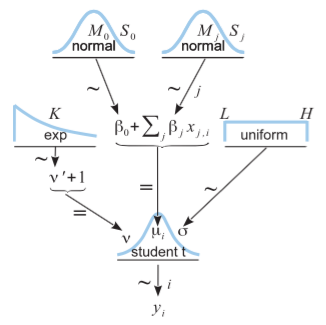

In [5]:
Image('images/fig18_4.png', width=400)

In [6]:
with pm.Model() as model:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(2))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

In [7]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 42.951: 100%|██████████| 200000/200000 [00:25<00:00, 7746.77it/s]
Finished [100%]: Average Loss = 42.951
 99%|█████████▉| 10432/10500 [00:14<00:00, 726.14it/s]/Users/jordi/anaconda/envs/probalistic/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 0 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)
100%|██████████| 10500/10500 [00:14<00:00, 727.92it/s]


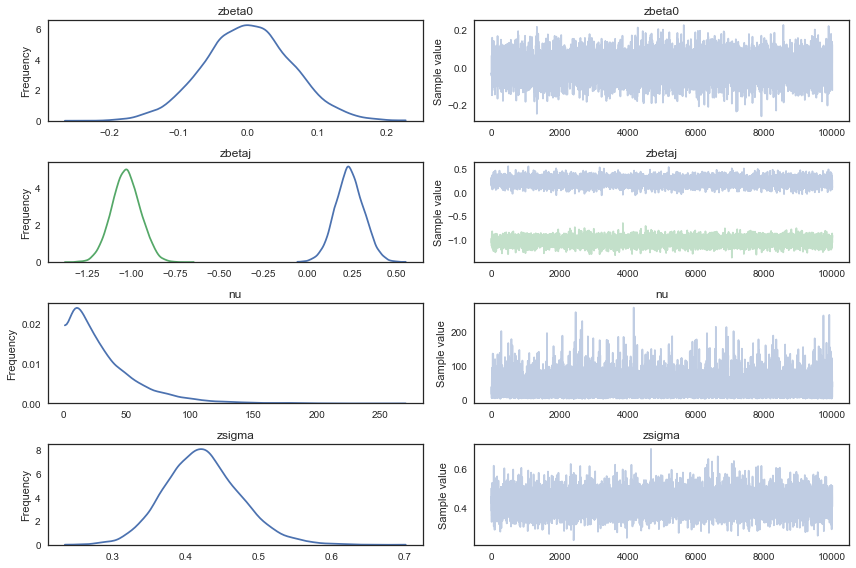

In [8]:
pm.traceplot(trace);

#### Figure 18.5

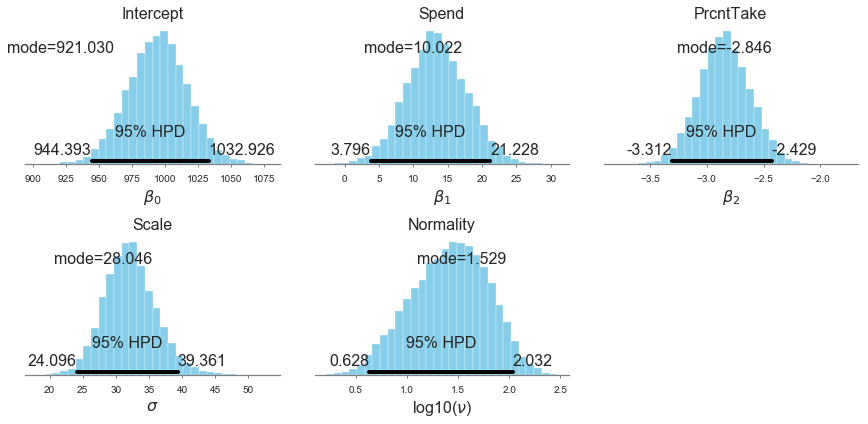

In [9]:
# Transform parameters back to original scale
burnin = 100
beta0 = trace['zbeta0']*scaley + meany - np.sum(trace['zbetaj']*meanx/scalex, axis=1)*scaley
betaj = (trace['zbetaj']/scalex)*scaley
scale = (trace['zsigma']*scaley)[burnin:]

intercept = beta0[burnin:]
spend = betaj[:,0][burnin:]
prcnttake =  betaj[:,1][burnin:]
normality = np.log10(trace['nu'][burnin:])

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(12,6))

for ax, estimate, title, xlabel in zip(fig.axes,
                               [intercept, spend, prcnttake, scale, normality],
                               ['Intercept', 'Spend', 'PrcntTake', 'Scale', 'Normality'],
                               [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$', r'$\sigma$', r'log10($\nu$)']):
    pm.plot_posterior(estimate, point_estimate='mode', ax=ax, color=color)
    ax.set_title(title, fontdict=f_dict)
    ax.set_xlabel(xlabel, fontdict=f_dict)

fig.tight_layout()
ax6.set_visible(False)

Below we create the scatterplots of figure 18.5 using `pairplot()` in seaborn and then tweak the lower triangle.

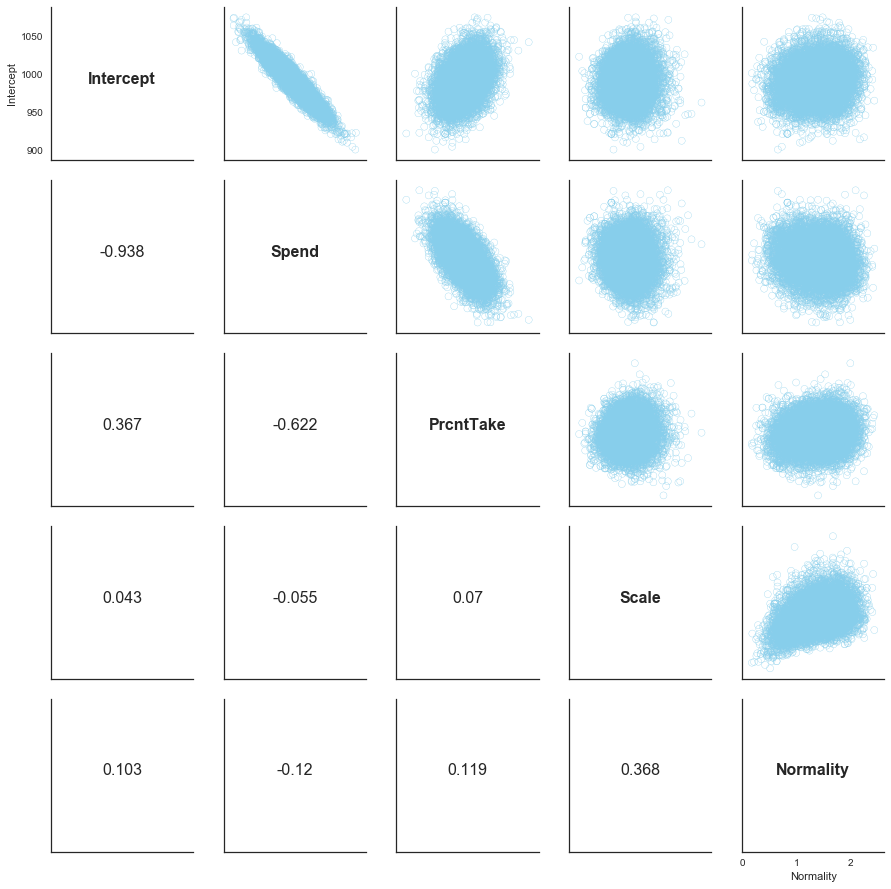

In [10]:
# DataFrame with the columns in correct order
pair_plt = pd.DataFrame({'Intercept':intercept,
                         'Spend':spend,
                         'PrcntTake': prcnttake,
                         'Scale':scale,
                         'Normality': normality},
                        columns=['Intercept', 'Spend', 'PrcntTake', 'Scale', 'Normality'])

# Correlation coefficients
corr = np.round(np.corrcoef(pair_plt, rowvar=0), decimals=3)
# Indexes of the lower triangle, below the diagonal
lower_idx = np.tril(corr, -1).nonzero()

# The seaborn pairplot
pgrid = sns.pairplot(pair_plt, plot_kws={'edgecolor':color, 'facecolor':'none'})

# Replace the plots on the diagonal with the parameter names
for i, ax in enumerate(pgrid.diag_axes):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, pair_plt.columns[i], transform=ax.transAxes, fontdict={'size':16, 'weight':'bold'}, ha='center') 

# Replace the lower triangle with the correlation coefficients
for i, ax in enumerate(pgrid.axes[lower_idx]):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, corr[lower_idx][i], transform=ax.transAxes, fontdict=f_dict, ha='center')

### 18.1.4 - Redundant predictors

In [11]:
X2 = X.assign(PropNotTake = lambda x: (100-x.PrcntTake)/100)

meanx2 = X2.mean().values
scalex2 = X2.std().values
zX2 = ((X2-meanx2)/scalex2).values

In [12]:
with pm.Model() as model2:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(3))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX2.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)    

In [13]:
with model2:
    trace2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 46.382: 100%|██████████| 200000/200000 [00:25<00:00, 7984.08it/s]
Finished [100%]: Average Loss = 46.369
100%|██████████| 5500/5500 [00:24<00:00, 221.48it/s]


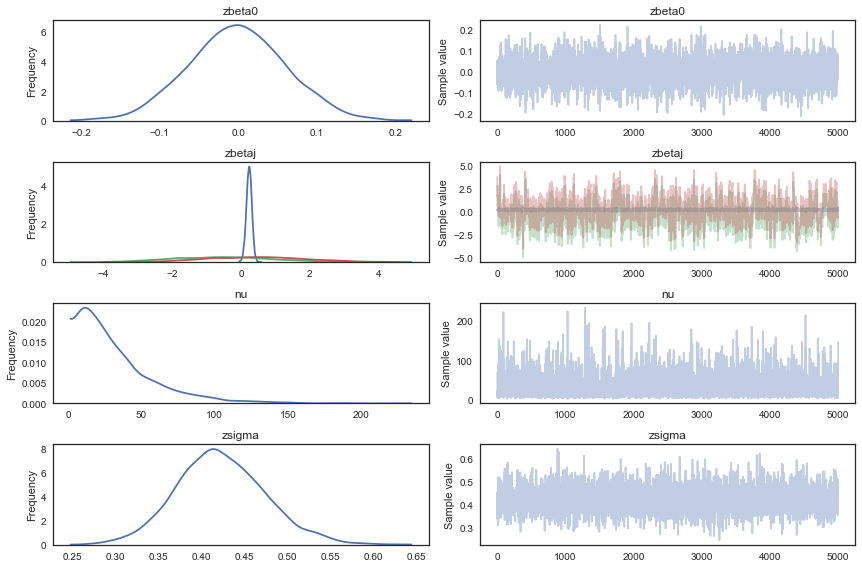

In [14]:
pm.traceplot(trace2);

#### Figure 18.6

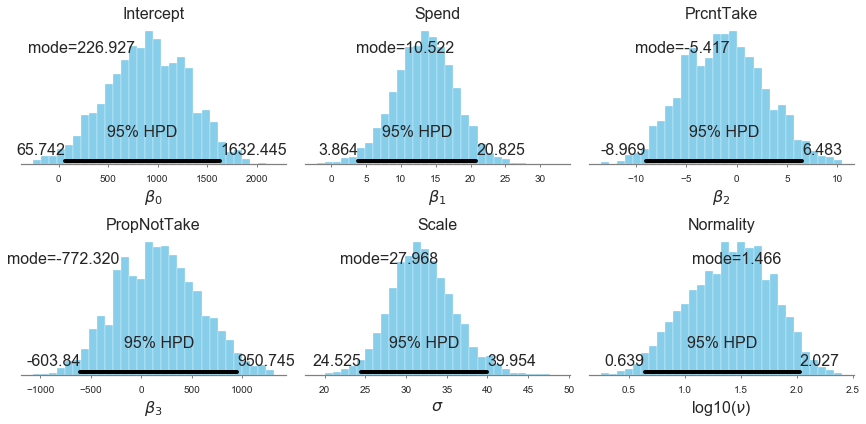

In [15]:
# Transform parameters back to original scale
burnin = 200
beta0 = trace2['zbeta0']*scaley + meany - np.sum(trace2['zbetaj']*meanx2/scalex2, axis=1)*scaley
betaj = (trace2['zbetaj']/scalex2)*scaley
scale = (trace2['zsigma']*scaley)[burnin:]

intercept = beta0[burnin:]
spend = betaj[:,0][burnin:]
prcnttake =  betaj[:,1][burnin:]
propnottake =  betaj[:,2][burnin:]
normality = np.log10(trace2['nu'][burnin:])

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(12,6))

for ax, estimate, title, xlabel in zip(fig.axes,
                               [intercept, spend, prcnttake, propnottake, scale, normality],
                               ['Intercept', 'Spend', 'PrcntTake', 'PropNotTake', 'Scale', 'Normality'],
                               [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\sigma$', r'log10($\nu$)']):
    pm.plot_posterior(estimate, point_estimate='mode', ax=ax, color=color)
    ax.set_title(title, fontdict=f_dict)
    ax.set_xlabel(xlabel, fontdict=f_dict)

plt.tight_layout()

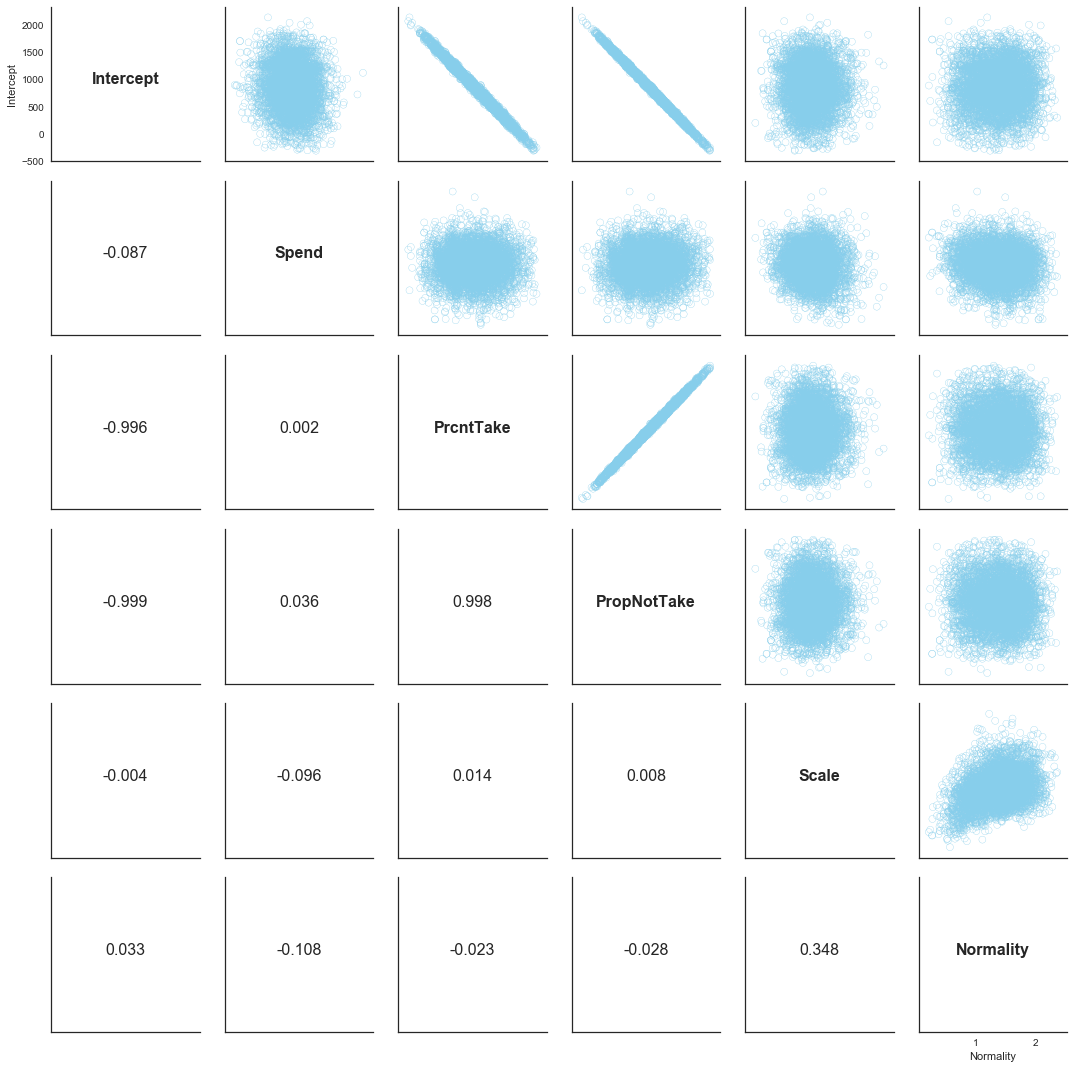

In [17]:
# DataFrame with the columns in correct order
pair_plt = pd.DataFrame({'Intercept':intercept,
                         'Spend':spend,
                         'PrcntTake': prcnttake,
                         'PropNotTake': propnottake,
                         'Scale':scale,
                         'Normality': normality},
                        columns=['Intercept', 'Spend', 'PrcntTake', 'PropNotTake', 'Scale', 'Normality'])

# Correlation coefficients
corr = np.round(np.corrcoef(pair_plt, rowvar=0), decimals=3)
# Indexes of the lower triangle, below the diagonal
lower_idx = np.tril(corr, -1).nonzero()

# The seaborn pairplot
pgrid = sns.pairplot(pair_plt, plot_kws={'edgecolor':color, 'facecolor':'none'})

# Replace the plots on the diagonal with the parameter names
for i, ax in enumerate(pgrid.diag_axes):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, pair_plt.columns[i], transform=ax.transAxes, fontdict={'size':16, 'weight':'bold'}, ha='center') 

# Replace the lower triangle with the correlation coefficients
for i, ax in enumerate(pgrid.axes[lower_idx]):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, corr[lower_idx][i], transform=ax.transAxes, fontdict=f_dict, ha='center')

### 18.2 - Multiplicative Interaction of Metric Predictors

In [18]:
X3 = X.assign(SpendXPrcnt = lambda x: x.Spend * x.PrcntTake)

meanx3 = X3.mean().values
scalex3 = X3.std().values
zX3 = ((X3-meanx3)/scalex3).values

In [19]:
# Correlation matrix
X3.corr()

,Spend,PrcntTake,SpendXPrcnt
Spend,1.000000,0.592627,0.775025
PrcntTake,0.592627,1.000000,0.951146
SpendXPrcnt,0.775025,0.951146,1.000000


In [20]:
with pm.Model() as model3:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(3))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX3.T)
        
    nu = pm.Exponential('nu', 1/30.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

In [21]:
with model3:
    trace3 = pm.sample(20000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 45.23: 100%|██████████| 200000/200000 [00:25<00:00, 7965.55it/s] 
Finished [100%]: Average Loss = 45.241
100%|█████████▉| 20477/20500 [00:49<00:00, 418.17it/s]/Users/jordi/anaconda/envs/probalistic/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 0 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)
100%|██████████| 20500/20500 [00:49<00:00, 411.73it/s]


#### Figure 18.9

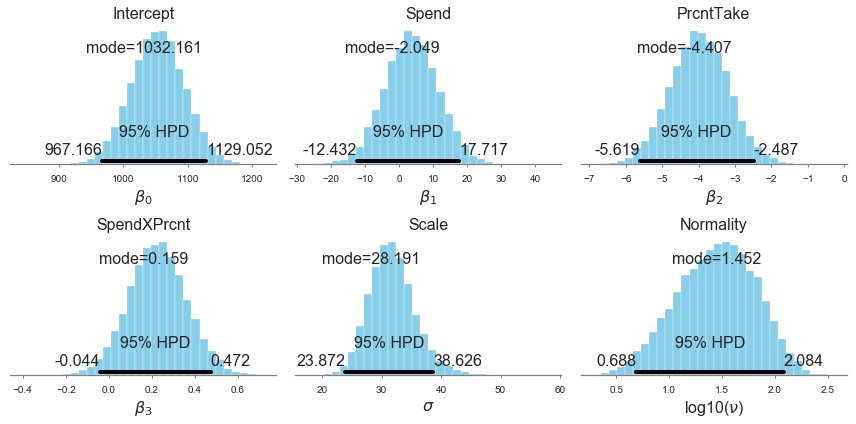

In [22]:
# Transform parameters back to original scale
burnin = 200
beta0 = trace3['zbeta0']*scaley + meany - np.sum(trace3['zbetaj']*meanx3/scalex3, axis=1)*scaley
betaj = (trace3['zbetaj']/scalex3)*scaley
scale = (trace3['zsigma']*scaley)[burnin:]

intercept = beta0[burnin:]
spend = betaj[:,0][burnin:]
prcnttake =  betaj[:,1][burnin:]
spendxprcnt =  betaj[:,2][burnin:]
normality = np.log10(trace3['nu'][burnin:])

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(12,6))

for ax, estimate, title, xlabel in zip(fig.axes,
                               [intercept, spend, prcnttake, spendxprcnt, scale, normality],
                               ['Intercept', 'Spend', 'PrcntTake', 'SpendXPrcnt', 'Scale', 'Normality'],
                               [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\sigma$', r'log10($\nu$)']):
    pm.plot_posterior(estimate, point_estimate='mode', ax=ax, color=color)
    ax.set_title(title, fontdict=f_dict)
    ax.set_xlabel(xlabel, fontdict=f_dict)

plt.tight_layout()

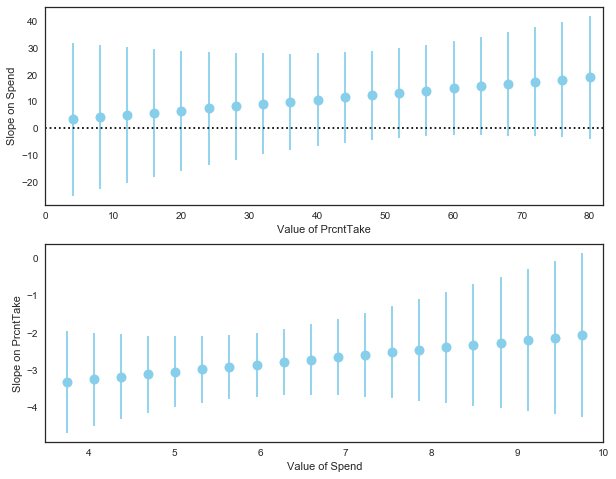

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

# Slope on Spend
prcnttake_values = np.linspace(4, 80, 20).reshape(1,-1)
spend_slope = spend.reshape(-1,1) + spendxprcnt.reshape(-1,1)*prcnttake_values
hpds = pm.hpd(spend_slope)
spend_slope_medians = np.mean(spend_slope, axis=0)

ax1.errorbar(prcnttake_values.ravel(), spend_slope_medians, yerr=hpds[:,1]-hpds[:,0],
             color=color, linestyle='None', marker='o', markersize=10)
ax1.axhline(linestyle='dotted', color='k')
ax1.set_xlim(0,82)
ax1.set(xlabel='Value of PrcntTake', ylabel='Slope on Spend')

# Slope on PrcntTake
spend_values = np.linspace(3.75, 9.75, 20)
prcnttake_slope = prcnttake.reshape(-1,1) + spendxprcnt.reshape(-1,1)*spend_values
hpds2 = pm.hpd(prcnttake_slope)
prcnttake_slope_medians = np.mean(prcnttake_slope, axis=0)

ax2.errorbar(spend_values.ravel(), prcnttake_slope_medians, yerr=hpds2[:,1]-hpds2[:,0],
             color=color, linestyle='None', marker='o', markersize=10)
ax2.set_xlim(3.5,10)
ax2.set(xlabel='Value of Spend', ylabel='Slope on PrcntTake');

### 18.3 - Shrinkage of Regression Coefficients

In *`R`* I ran the first 46 lines of code in the script `Jags-Ymet-XmetMulti-MrobustShrink-Example.R` to generate the exact same data used in the book. I exported the resulting data frame `myData` to a csv file.

In [24]:
df_shrink = pd.read_csv('data/18_3shrinkage.csv')
df_shrink.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 20 columns):
State        50 non-null object
Spend        50 non-null float64
StuTeaRat    50 non-null float64
Salary       50 non-null float64
PrcntTake    50 non-null int64
SATV         50 non-null int64
SATM         50 non-null int64
SATT         50 non-null int64
xRand1       50 non-null float64
xRand2       50 non-null float64
xRand3       50 non-null float64
xRand4       50 non-null float64
xRand5       50 non-null float64
xRand6       50 non-null float64
xRand7       50 non-null float64
xRand8       50 non-null float64
xRand9       50 non-null float64
xRand10      50 non-null float64
xRand11      50 non-null float64
xRand12      50 non-null float64
dtypes: float64(15), int64(4), object(1)
memory usage: 7.9+ KB


In [25]:
# Select the predictor columns: Spend, PrcntTake and the 12 randonly generated predictors
X4 = df_shrink.iloc[:, np.r_[[1,4], np.arange(8,20)]]
y4 = df_shrink.SATT

meanx4 = X4.mean().values
scalex4 = X4.std().values
zX4 = ((X4-meanx4)/scalex4).values

meany4 = y4.mean()
scaley4 = y4.std()
zy4 = ((y4-meany4)/scaley4).values

##### Hierarchical model with fixed, independent, vague normal priors

#### Model (Kruschke, 2015)

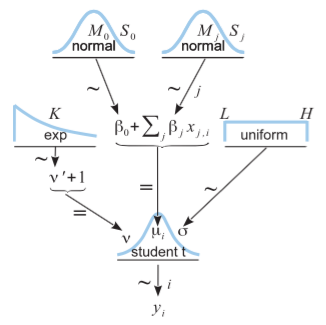

In [26]:
Image('images/fig18_4.png', width=400)

In [27]:
with pm.Model() as model4:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(zX4.shape[1]))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX4.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy4)

In [28]:
with model4:
    trace4 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 77.782: 100%|██████████| 200000/200000 [00:24<00:00, 8017.41it/s]
Finished [100%]: Average Loss = 77.793
100%|██████████| 5500/5500 [00:09<00:00, 590.41it/s]


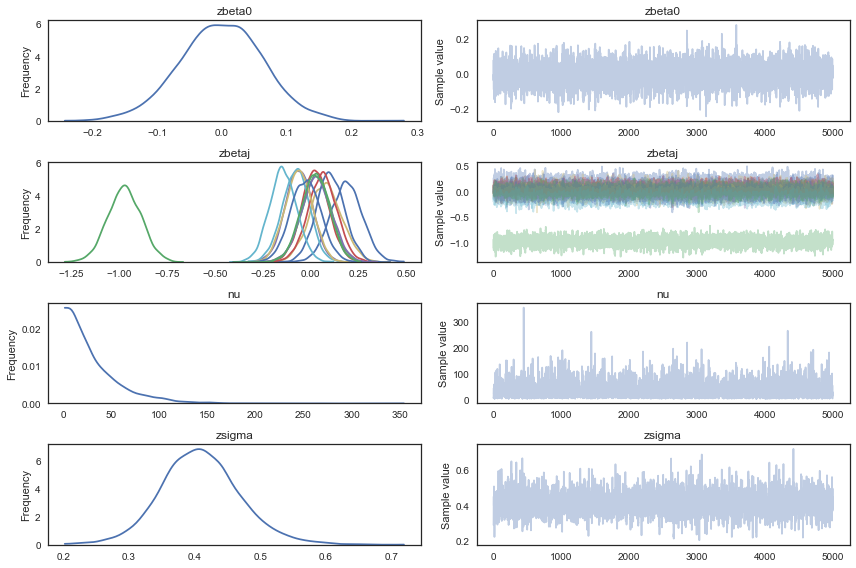

In [29]:
pm.traceplot(trace4);

#### Figure 18.11

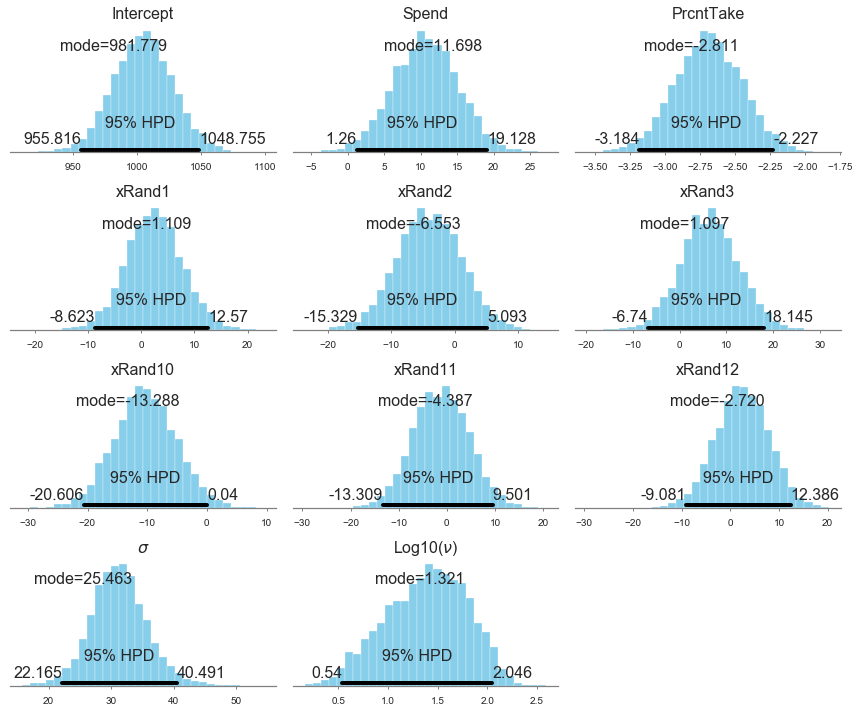

In [30]:
# Transform parameters back to original scale
burnin = 200
beta0 = trace4['zbeta0']*scaley4 + meany4 - np.sum(trace4['zbetaj']*meanx4/scalex4, axis=1)*scaley4
betaj = (trace4['zbetaj']/scalex4)*scaley4
scale = (trace4['zsigma']*scaley4)[burnin:]

intercept = beta0[burnin:]
spend = betaj[:,0][burnin:]
prcnttake =  betaj[:,1][burnin:]
normality = np.log10(trace4['nu'][burnin:])

fig, axes = plt.subplots(4,3, figsize=(12,10))

# Intercept
pm.plot_posterior(intercept, point_estimate='mode', ax=axes.flatten()[0], color=color)
axes.flatten()[0].set_title('Intercept', fontdict=f_dict)

# Spend & PrcntTale
pm.plot_posterior(spend, point_estimate='mode', ax=axes.flatten()[1], color=color)
axes.flatten()[1].set_title('Spend', fontdict=f_dict)
pm.plot_posterior(prcnttake, point_estimate='mode', ax=axes.flatten()[2], color=color)
axes.flatten()[2].set_title('PrcntTake', fontdict=f_dict)

# Randomly generated predictors
for ax, j in enumerate([2,3,4,11,12,13]):
    pm.plot_posterior(betaj[:,j], point_estimate='mode', ax=axes.flatten()[ax+3], color=color)
    axes.flatten()[ax+3].set_title(X4.columns[j], fontdict=f_dict)

# Scale
pm.plot_posterior(scale, point_estimate='mode', ax=axes.flatten()[9], color=color)
axes.flatten()[9].set_title(r'$\sigma$', fontdict=f_dict)

# Normality
pm.plot_posterior(normality, point_estimate='mode', ax=axes.flatten()[10], color=color)
axes.flatten()[10].set_title(r'Log10($\nu$)', fontdict=f_dict);

axes.flatten()[11].set_visible(False)

fig.tight_layout()

##### Hierarchical model with shrinkage

#### Model (Kruschke, 2015)

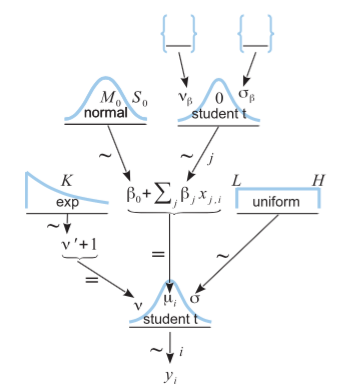

In [31]:
Image('images/fig18_10.png', width=400)

In [32]:
with pm.Model() as model5:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    
    sigmab = pm.Gamma('sigmab', mu=1., sd=1.) 
    zbetaj = pm.StudentT('zbetaj', nu=1, mu=0, sd=sigmab, shape=(zX4.shape[1]))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX4.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy4)

In [33]:
with model5:
    trace5 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 50.655: 100%|██████████| 200000/200000 [00:32<00:00, 6248.78it/s]
Finished [100%]: Average Loss = 50.661
100%|██████████| 10500/10500 [00:32<00:00, 325.20it/s]


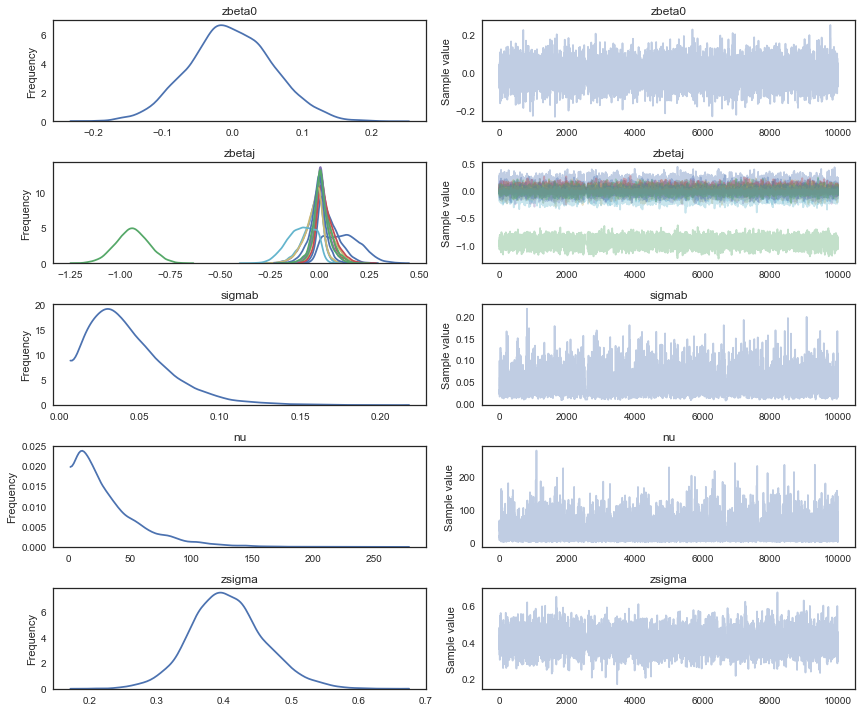

In [34]:
pm.traceplot(trace5);

#### Figure 18.12

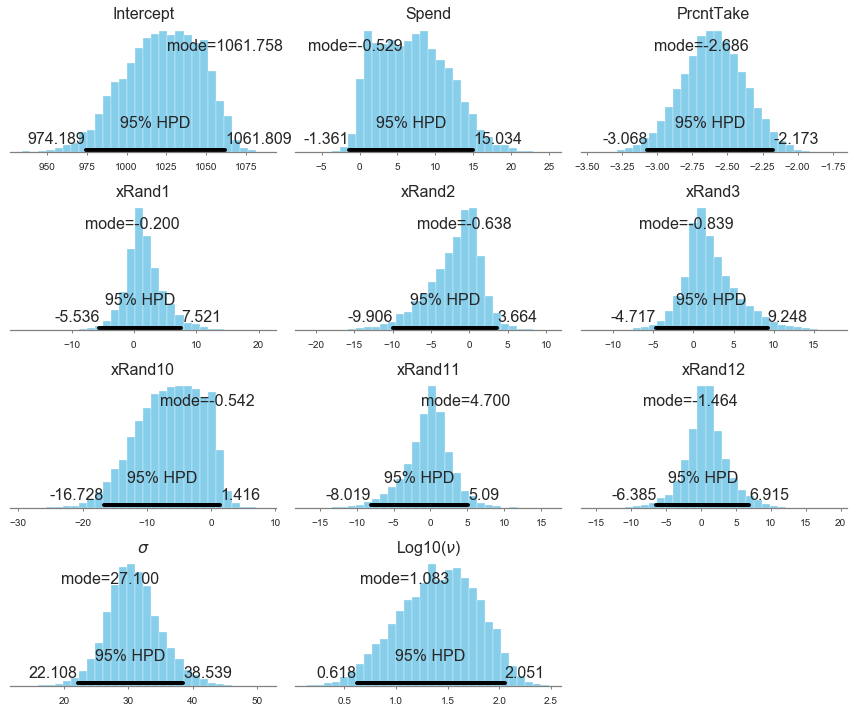

In [35]:
# Transform parameters back to original scale
burnin = 200
beta0 = trace5['zbeta0']*scaley4 + meany4 - np.sum(trace5['zbetaj']*meanx4/scalex4, axis=1)*scaley4
betaj = (trace5['zbetaj']/scalex4)*scaley4
scale = (trace5['zsigma']*scaley4)[burnin:]

intercept = beta0[burnin:]
spend = betaj[:,0][burnin:]
prcnttake =  betaj[:,1][burnin:]
normality = np.log10(trace5['nu'][burnin:])

fig, axes = plt.subplots(4,3, figsize=(12,10))

# Intercept
pm.plot_posterior(intercept, point_estimate='mode', ax=axes.flatten()[0], color=color)
axes.flatten()[0].set_title('Intercept', fontdict=f_dict)

# Spend & PrcntTale
pm.plot_posterior(spend, point_estimate='mode', ax=axes.flatten()[1], color=color)
axes.flatten()[1].set_title('Spend', fontdict=f_dict)
pm.plot_posterior(prcnttake, point_estimate='mode', ax=axes.flatten()[2], color=color)
axes.flatten()[2].set_title('PrcntTake', fontdict=f_dict)

# Randomly generated predictors
for ax, j in enumerate([2,3,4,11,12,13]):
    pm.plot_posterior(betaj[:,j], point_estimate='mode', ax=axes.flatten()[ax+3], color=color)
    axes.flatten()[ax+3].set_title(X4.columns[j], fontdict=f_dict)

# Scale
pm.plot_posterior(scale, point_estimate='mode', ax=axes.flatten()[9], color=color)
axes.flatten()[9].set_title(r'$\sigma$', fontdict=f_dict)

# Normality
pm.plot_posterior(normality, point_estimate='mode', ax=axes.flatten()[10], color=color)
axes.flatten()[10].set_title(r'Log10($\nu$)', fontdict=f_dict);

axes.flatten()[11].set_visible(False)

fig.tight_layout()

### 18.4 - Variable Selection

#### sd = 2

In [36]:
with pm.Model() as model6:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2.)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=2., shape=(zX.shape[1]))
    deltaj = pm.Bernoulli('deltaj', 0.5, shape=(zX.shape[1]))
    
    zmu =  zbeta0 + pm.math.dot(deltaj*zbetaj, zX.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

In [37]:
with model6:
    trace6 = pm.sample(5000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned BinaryGibbsMetropolis to deltaj
Assigned NUTS to nu_log__
Assigned NUTS to zsigma_interval__
100%|██████████| 5500/5500 [00:23<00:00, 229.22it/s]


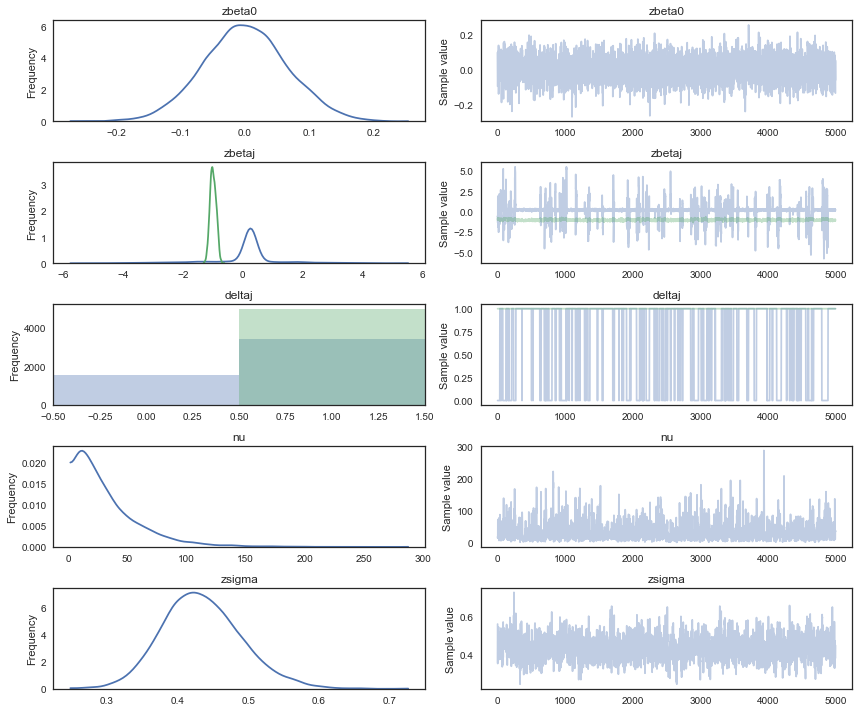

In [38]:
pm.traceplot(trace6);

In [39]:
def plot_models(trace, burnin=200):

    # Transform parameters back to original scale
    beta0 = trace['zbeta0']*scaley + meany - np.sum(trace['deltaj']*trace['zbetaj']*meanx/scalex, axis=1)*scaley
    betaj = (trace['deltaj']*trace['zbetaj']/scalex)*scaley
    scale = trace['zsigma']*scaley

    # Get the indexes and probabilities of the two models: full model and model with just prcnttake
    full_model_idx = np.where(np.equal(trace['deltaj'], (1,1)).all(axis=1))
    full_model_prob = np.sum(np.equal(trace['deltaj'], (1,1)).all(axis=1))/len(trace[trace.varnames[0]])
    prcnttake_model_idx = np.where(np.equal(trace['deltaj'], (0,1)).all(axis=1))
    prcnttake_model_prob = np.sum(np.equal(trace['deltaj'], (0,1)).all(axis=1))/len(trace[trace.varnames[0]])

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,3))
    fig.suptitle('Model Prob = {}'.format(full_model_prob), fontsize=20)
    pm.plot_posterior(beta0[full_model_idx][burnin:], point_estimate='mean', ax=ax1, color=color)
    ax1.set_xlabel('Intercept', fontdict=f_dict)
    
    pm.plot_posterior(betaj[full_model_idx,0].ravel()[burnin:], point_estimate='mean', ax=ax2, color=color)
    ax2.set_xlabel('Spend', fontdict=f_dict)
    pm.plot_posterior(betaj[full_model_idx,1].ravel()[burnin:], point_estimate='mean', ax=ax3, color=color)
    ax3.set_xlabel('PrcntTake', fontdict=f_dict)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,3))
    fig.suptitle('Model Prob = {}'.format(prcnttake_model_prob), fontsize=20)
    pm.plot_posterior(beta0[prcnttake_model_idx][burnin:], point_estimate='mean', ax=ax1, color=color)
    ax1.set_xlabel('Intercept', fontdict=f_dict)
    pm.plot_posterior(betaj[prcnttake_model_idx,1].ravel()[burnin:], point_estimate='mean', ax=ax3, color=color)
    ax3.set_xlabel('PrcntTake', fontdict=f_dict)
    ax2.set_visible(False);

#### Figure 18.13

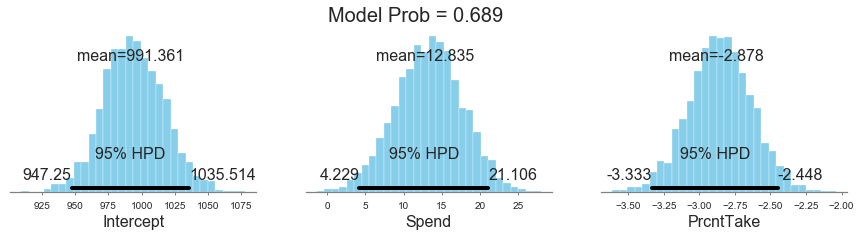

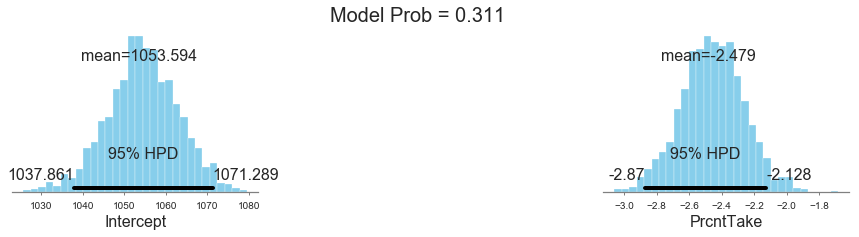

In [40]:
plot_models(trace6)

#### sd = 1

In [41]:
with pm.Model() as model7:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=1.)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=1., shape=(zX.shape[1]))
    deltaj = pm.Bernoulli('deltaj', 0.5, shape=(zX.shape[1]))
    
    zmu =  zbeta0 + pm.math.dot(deltaj*zbetaj, zX.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

In [42]:
with model7:
    trace7 = pm.sample(5000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned BinaryGibbsMetropolis to deltaj
Assigned NUTS to nu_log__
Assigned NUTS to zsigma_interval__
100%|██████████| 5500/5500 [00:19<00:00, 289.29it/s]


#### Figure 18.14 (top)

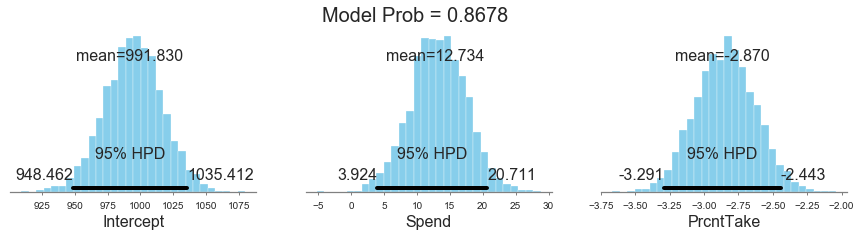

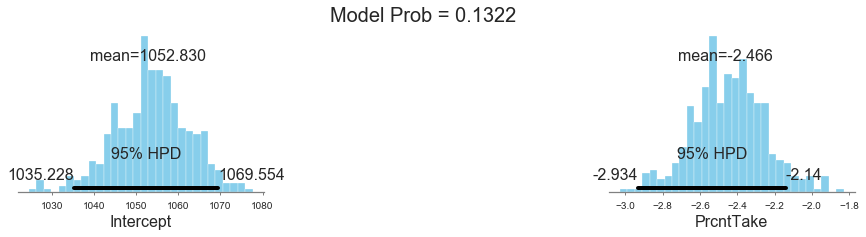

In [43]:
plot_models(trace7)

#### sd = 10

In [44]:
with pm.Model() as model8:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=10.)
    zbetaj = pm.Normal('zbetaj', mu=0, sd=10., shape=(zX.shape[1]))
    deltaj = pm.Bernoulli('deltaj', 0.5, shape=(zX.shape[1]))
    
    zmu =  zbeta0 + pm.math.dot(deltaj*zbetaj, zX.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

In [45]:
with model8:
    trace8 = pm.sample(5000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned BinaryGibbsMetropolis to deltaj
Assigned NUTS to nu_log__
Assigned NUTS to zsigma_interval__
100%|██████████| 5500/5500 [01:04<00:00, 84.66it/s] 


#### Figure 18.14 (bottom)

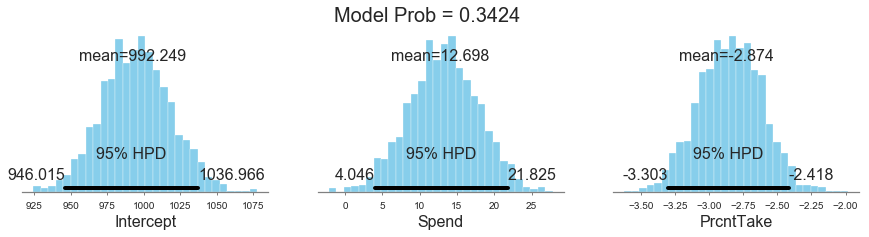

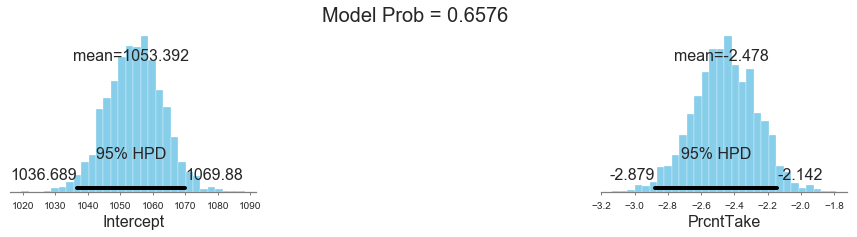

In [46]:
plot_models(trace8)

### 18.4.2 - Variable Selection with hierarchical shrinkage

In [47]:
X5 = df[['Spend', 'PrcntTake', 'StuTeaRat', 'Salary']]
X5.corr()

,Spend,PrcntTake,StuTeaRat,Salary
Spend,1.000000,0.592627,-0.371025,0.869802
PrcntTake,0.592627,1.000000,-0.213054,0.616780
StuTeaRat,-0.371025,-0.213054,1.000000,-0.001146
Salary,0.869802,0.616780,-0.001146,1.000000


In [48]:
meanx5 = X5.mean().values
scalex5 = X5.std().values
zX5 = ((X5-meanx5)/scalex5).values

In [49]:
with pm.Model() as model9:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    
    sigmab = pm.Gamma('sigmab', alpha=1.1051, beta=0.1051) 
    zbetaj = pm.StudentT('zbetaj', nu=1, mu=0, sd=sigmab, shape=(zX5.shape[1]))
    deltaj = pm.Bernoulli('deltaj', 0.5, shape=(zX5.shape[1]))
    
    zmu =  zbeta0 + pm.math.dot(deltaj*zbetaj, zX5.T)
        
    nu = pm.Exponential('nu', 1/30.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)     

In [59]:
with model9:
    trace9 = pm.sample(20000)

Assigned NUTS to zbeta0
Assigned NUTS to sigmab_log__
Assigned NUTS to zbetaj
Assigned BinaryGibbsMetropolis to deltaj
Assigned NUTS to nu_log__
Assigned NUTS to zsigma_interval__
100%|█████████▉| 20499/20500 [09:22<00:00, 22.05it/s] /Users/jordi/anaconda/envs/probalistic/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:255: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % chain)
100%|██████████| 20500/20500 [09:22<00:00, 36.46it/s]


In [61]:
def plot_models2(trace, model):

    # Transform parameters back to original scale
    beta0 = trace['zbeta0']*scaley + meany - np.sum(trace['deltaj']*trace['zbetaj']*meanx5/scalex5, axis=1)*scaley
    betaj = (trace['deltaj']*trace['zbetaj']/scalex5)*scaley
    scale = trace['zsigma']*scaley

    # Get the indexes and probabilities of the model
    model_idx = np.where(np.equal(trace['deltaj'], model).all(axis=1))
    model_prob = np.sum(np.equal(trace['deltaj'], model).all(axis=1))/len(trace[trace.varnames[0]])
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(17,2))
    fig.suptitle('Model Prob = {}'.format(model_prob), fontsize=20)  
        
    pm.plot_posterior(beta0[model_idx], point_estimate='mean', ax=ax1, color=color)
    ax1.set_xlabel('Intercept', fontdict=f_dict)
    
    for i, ax, xlabel in zip([0,1,2,3],
                                 [ax2, ax3, ax4, ax5],
                                 ['Spend', 'PrcntTake', 'StuTeaRate', 'Salary']):
        pm.plot_posterior(betaj[model_idx,i].ravel(), point_estimate='mean', ax=ax, color=color)
        ax.set_xlabel(xlabel, fontdict=f_dict)

    # Only show posteriors for predictors that are part of the model
    for ax, m in zip([ax2, ax3, ax4, ax5], model):
        ax.set_visible(bool(m))

#### Figure 18.15

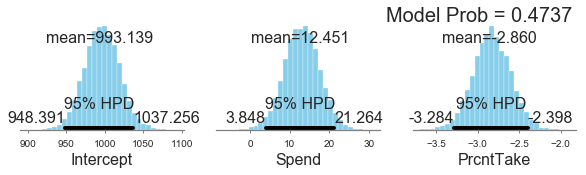

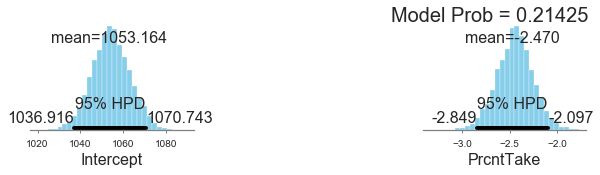

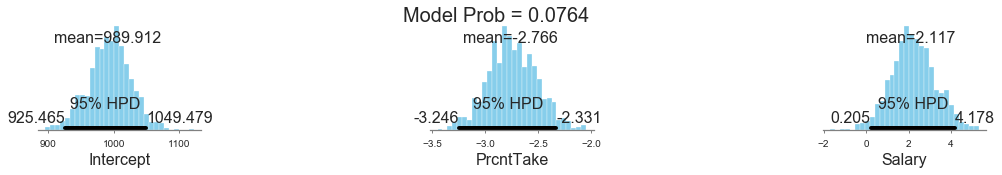

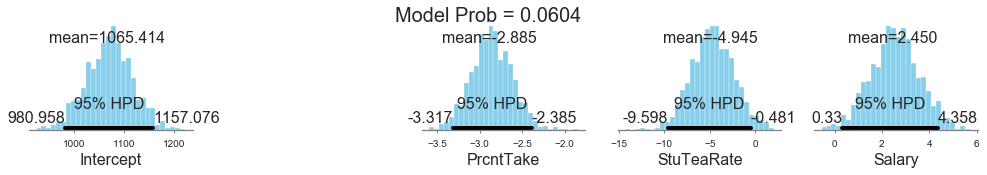

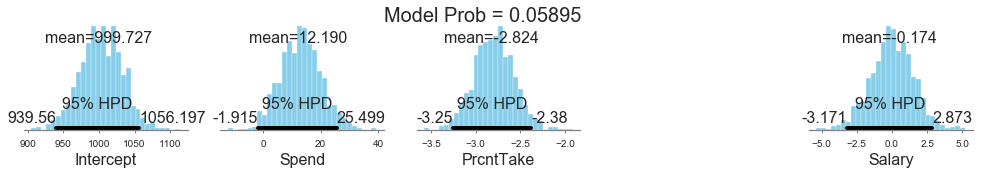

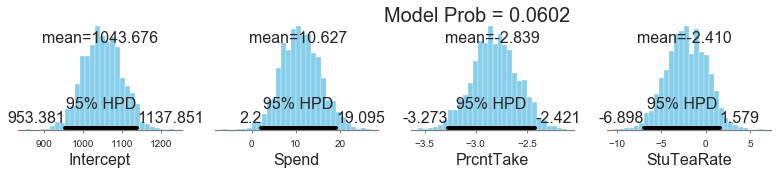

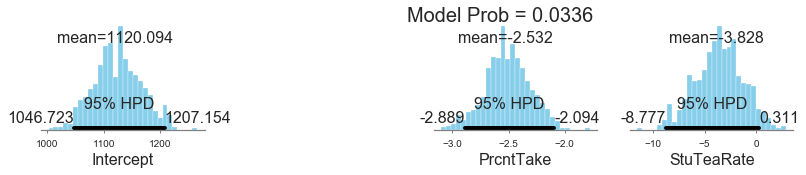

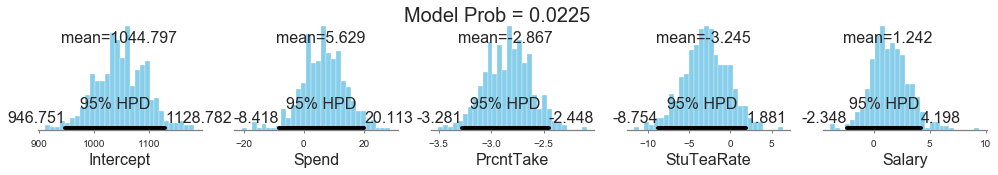

In [62]:
# Encode 8 models with different sets of predictors in a list of tuples
models = [(1,1,0,0),
         (0,1,0,0),
         (0,1,0,1),
         (0,1,1,1),
         (1,1,0,1),
         (1,1,1,0),
         (0,1,1,0),
         (1,1,1,1,)]

[plot_models2(trace9, m) for m in models];